# Data Analytics - ML25M 

### Imports

In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)
random.seed(seed)

## Data Acquisition

movies.csv contains the following fields:

* movieId - a unique identifier for each movie.
* title - the title of the movie.
* genres - a pipe-separated list of genres for the movie.

It will be used to get the movie title and the genres.

In [3]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
genres = movies_df['genres'].str.get_dummies(sep='|')
movies_df = pd.concat([movies_df, genres], axis=1)
movies_genres = movies_df.copy()
movies_genres.drop('genres', axis=1, inplace=True)


movies_df.drop('genres', axis=1, inplace=True)
movies_df.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


genome-scores.csv contains the following fields:

* movieId - a unique identifier for each movie.
* tagId - a unique identifier for each tag.
* relevance - a score from 0.0 to 1.0 representing the relevance of the tag to the movie.

Combined with the tags.csv file, this will be used to assign tags and their relevance to each movie.

In [4]:
scores_df = pd.read_csv('./ml-25m/genome-scores.csv')
tags_df = pd.read_csv('./ml-25m/genome-tags.csv')
ratings_df = pd.read_csv('./ml-25m/ratings.csv')

df = movies_df.merge(scores_df, on='movieId')
df = df.merge(tags_df, on='tagId')
df = df.pivot_table(index=['movieId', 'title'], columns='tag', values='relevance', fill_value=0).reset_index().rename_axis(None, axis=1)

# average rating for each movie
ratings_df = ratings_df.groupby(['movieId'])['rating'].mean().reset_index()
df = ratings_df.merge(df, on='movieId')

movies_genres = movies_genres.merge(ratings_df, on='movieId')
movies_genres.drop('movieId', axis=1, inplace=True)

# movieId and title are not needed for the model
df.drop(['movieId', 'title'], axis=1, inplace=True)

In [5]:
# save the dataframe to a csv file
df.to_csv('./dataset.csv', index=False)

## Data visualization

In [6]:
print(f'Number of samples: {df.shape[0]}')
df.describe()

Number of samples: 13816


,rating,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
count,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,...,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000
mean,3.272180,0.046596,0.044771,0.078292,0.085599,0.129250,0.088348,0.074092,0.180610,0.096887,...,0.117631,0.043644,0.048769,0.062500,0.245069,0.097053,0.041831,0.042961,0.125901,0.031766
std,0.484078,0.071478,0.062601,0.111595,0.086021,0.146648,0.105167,0.100385,0.140021,0.134208,...,0.136072,0.083196,0.146318,0.083094,0.122572,0.089406,0.074281,0.135702,0.104373,0.084668
min,0.899038,0.007000,0.007250,0.006000,0.010000,0.017250,0.004250,0.004500,0.015250,0.002250,...,0.009250,0.004000,0.002500,0.003500,0.039750,0.006750,0.005250,0.001500,0.034750,0.007750
25%,2.986574,0.025750,0.026750,0.028750,0.037250,0.053250,0.029500,0.024500,0.079750,0.024750,...,0.052000,0.017250,0.011000,0.022500,0.160250,0.042000,0.021500,0.008500,0.081500,0.016500
50%,3.340420,0.033750,0.034750,0.042000,0.056000,0.078250,0.052750,0.041500,0.137750,0.047750,...,0.072250,0.022500,0.015250,0.039750,0.216500,0.069000,0.028000,0.012250,0.097500,0.019000
75%,3.629630,0.045312,0.047250,0.079500,0.102250,0.136000,0.101500,0.078750,0.235750,0.107250,...,0.118250,0.034000,0.024000,0.074000,0.296250,0.119000,0.038312,0.020000,0.126000,0.023500
max,4.483096,0.999750,1.000000,0.997750,0.922000,0.988000,0.920000,0.913500,0.925500,0.987000,...,0.999250,0.981000,0.999000,0.992750,0.972500,0.974750,1.000000,0.995250,0.992250,0.994250


In [7]:
# mean, median, and standard deviation of ratings
print("Mode: ", df['rating'].mode())
print('Median: {:.2f}'.format(df['rating'].median()))
print('Std: {:.2f}'.format(df['rating'].std()))

Mode:  0    3.5
Name: rating, dtype: float64
Median: 3.34
Std: 0.48


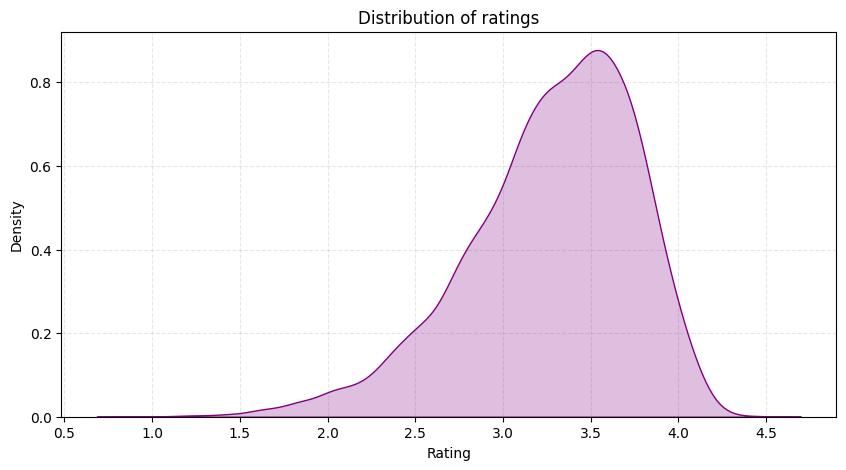

In [8]:
# density plot of ratings
plt.figure(figsize=(10, 5))
sns.kdeplot(df['rating'], shade=True, color='purple', zorder=2)
plt.grid(True, zorder=1, linestyle='--', alpha=0.3)
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.show()

In [9]:
N_LABELS = df.rating.nunique()
print(f'Number of labels: {N_LABELS}')

# looking for missing values and duplicates
print("Nan: ", df.isna().sum().sum())
print("Duplicates: ", df.duplicated().sum())

Number of labels: 12002
Nan:  0
Duplicates:  0


mu: 3.27, sigma: 0.48, variance: 0.23
stat=0.057, p=0.000
Probably different distributions


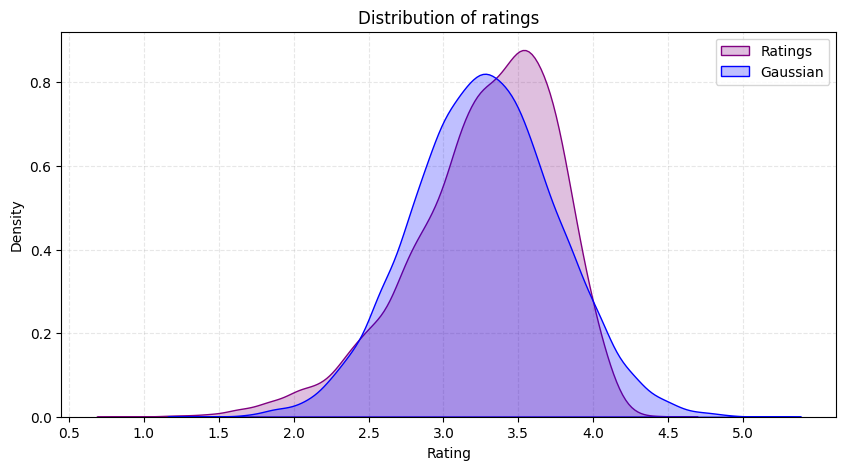

In [10]:
# compare rating distribution with gaussian distribution
# Kolmogorov-Smirnov test,
# H0: the two distributions are the same
# H1: the two distributions are different
from scipy.stats import kstest
from scipy.stats import norm

# mean and standard deviation of ratings
mu = df['rating'].mean()
sigma = df['rating'].std()
variance = sigma**2

print(f'mu: {mu:.2f}, sigma: {sigma:.2f}, variance: {variance:.2f}')

# generate random samples from a normal distribution
samples = np.random.normal(mu, sigma, df.shape[0])

# compare the two distributions
stat, p = kstest(df['rating'], 'norm', args=(mu, sigma))
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

# plot the two distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(df['rating'], shade=True, color='purple', zorder=2, label='ratings')
sns.kdeplot(samples, shade=True, color='blue', zorder=2, label='gaussian')
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.grid(True, zorder=1, linestyle='--', alpha=0.3)
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.legend(['Ratings', 'Gaussian'])
plt.show()

In [11]:
# distance from normal distribution
# mean absolute error
mae = np.abs(df['rating'] - samples).mean()

# mean squared error
mse = np.square(df['rating'] - samples).mean()

# root mean squared error
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')

MAE: 0.54, MSE: 0.47, RMSE: 0.68


In [12]:
# Kullback-Leibler divergence
# H0: the two distributions are the same
# H1: the two distributions are different
from scipy.stats import entropy

# calculate KL divergence
kl = entropy(df['rating'], samples)

print(f'KL: {kl:.2f}')

KL: 0.02


## Correlation between genres and ratings

/var/folders/b3/wwdp9x6d2_3fvz33_v4d_k_80000gn/T/ipykernel_23533/2091473739.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = movies_genres.corr()


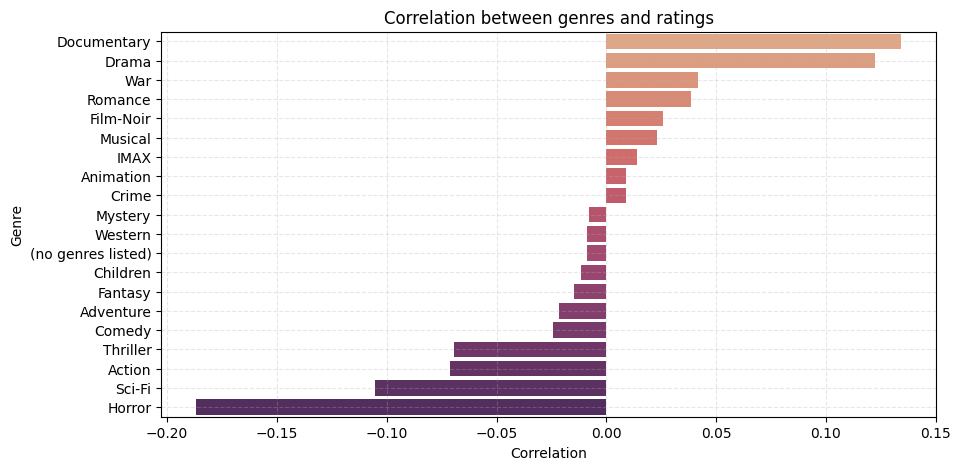

In [65]:
# calculate the correlation between genres and ratings
corr = movies_genres.corr()
corr = corr['rating'].sort_values(ascending=False)
corr = corr[1:]

# plot the correlation
plt.figure(figsize=(10, 5))
sns.barplot(x=corr.values, y=corr.index, palette='flare')
plt.grid(True, zorder=1, linestyle='--', alpha=0.3)
plt.title('Correlation between genres and ratings')
plt.xlabel('Correlation')
plt.ylabel('Genre')
plt.show()

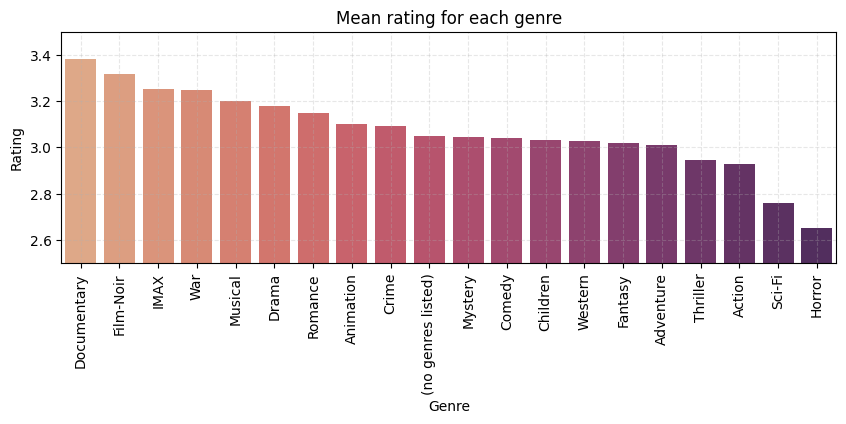

In [62]:
# mean rating for each genre
genres = movies_genres.columns[1:]
genres_rating = pd.DataFrame(columns=['genre', 'rating'])
for genre in genres:
    rating = movies_genres[movies_genres[genre] == 1]['rating'].mean()
    genres_rating = pd.concat([genres_rating, pd.DataFrame([[genre, rating]], columns=['genre', 'rating'])])

genres_rating = genres_rating[genres_rating['genre'] != 'rating']

# order the genres by rating
genres_rating = genres_rating.sort_values(by='rating', ascending=False)

# plot the mean rating for each genre
plt.figure(figsize=(10, 3))
sns.barplot(x='genre', y='rating', data=genres_rating, palette='flare')
plt.xticks(rotation=90)
plt.grid(True, zorder=1, linestyle='--', alpha=0.3)
plt.ylim(2.5, 3.5)
plt.title('Mean rating for each genre')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.show()

## 2D Representation of the dataset

In [87]:
df_random = df.sample(13000)

X = df_random.drop('rating', axis=1)
Y = df_random['rating']

In [88]:
# tsne 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1, perplexity=50, n_iter=500, verbose=1)
X = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 13000 samples in 0.022s...
[t-SNE] Computed neighbors for 13000 samples in 1.674s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13000
[t-SNE] Computed conditional probabilities for sample 2000 / 13000
[t-SNE] Computed conditional probabilities for sample 3000 / 13000
[t-SNE] Computed conditional probabilities for sample 4000 / 13000
[t-SNE] Computed conditional probabilities for sample 5000 / 13000
[t-SNE] Computed conditional probabilities for sample 6000 / 13000
[t-SNE] Computed conditional probabilities for sample 7000 / 13000
[t-SNE] Computed conditional probabilities for sample 8000 / 13000
[t-SNE] Computed conditional probabilities for sample 9000 / 13000
[t-SNE] Computed conditional probabilities for sample 10000 / 13000
[t-SNE] Computed conditional probabilities for sample 11000 / 13000
[t-SNE] Computed conditional probabilities for sample 12000 / 13000
[t-SNE] Computed conditional probabilities for sa

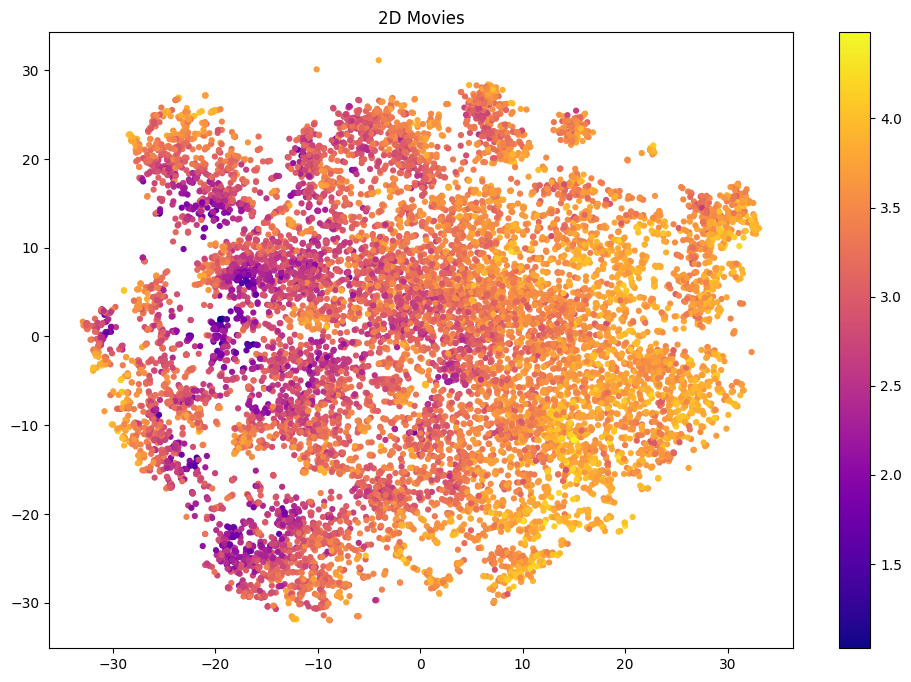

In [89]:
# plot
plt.figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='plasma',s=12)
plt.title('2D Movies')
plt.colorbar()
plt.show()